# Plotting multispectral data

Multispectral data can be plotted as:

1.  Individual bands
2.  Spectral indices
3.  True color 3-band images
4.  False color 3-band images

Spectral indices and false color images can both be used to enhance
images to clearly show things that might be hidden from a true color
image, such as vegetation health.

In [81]:
%store -r band_dict ndvi_da denver_redlining_gdf

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Import libraries</div></div><div class="callout-body-container callout-body"><p>Add missing libraries to the imports</p></div></div>

In [82]:
import cartopy.crs as ccrs # CRSs
# Interactive tabular and vector data
import hvplot.xarray # Interactive raster
# Overlay plots
import numpy as np # Adjust images
import xarray as xr # Adjust images
import matplotlib.pyplot as plt
import hvplot
import cartopy
import scipy
import pykdtree


There are many different ways to represent geospatial coordinates,
either spherically or on a flat map. These different systems are called
Coordinate Reference Systems.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Prepare to plot</div></div><div class="callout-body-container callout-body"><p>To make interactive geospatial plots, at the moment we need
everything to be in the Mercator CRS.</p>
<ol type="1">
<li>Reproject your area of interest with
<code>.to_crs(ccrs.Mercator())</code></li>
<li>Reproject your NDVI and band raster data using
`.rio.reproject(ccrs.Mercator())</li>
</ol></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Plot raster with overlay with xarray</div></div><div class="callout-body-container callout-body"><p>Plotting raster and vector data together using <code>pandas</code>
and <code>xarray</code> requires the <code>matplotlib.pyplot</code>
library to access some plot layour tools. Using the code below as a
starting point, you can play around with adding:</p>
<ol type="1">
<li>Labels and titles</li>
<li>Different colors with <code>cmap</code> and
<code>edgecolor</code></li>
<li>Different line thickness with <code>line_width</code></li>
</ol>
<p>See if you can also figure out what <code>vmin</code>,
<code>robust</code>, and the <code>.set()</code> methods do.</p></div></div>

In [83]:
denver_ndvi_da=ndvi_da.rio.reproject(ccrs.Mercator())
aoi_plot_gdf=denver_redlining_gdf.to_crs(ccrs.Mercator())
band_plot_dict={name: da.rio.reproject(ccrs.Mercator()) for name, da in band_dict.items()}

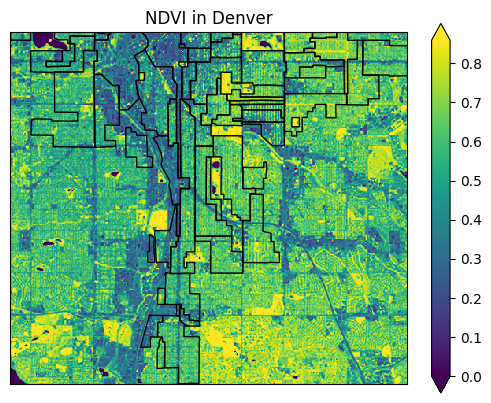

In [84]:
denver_ndvi_da.plot(vmin=0, robust=True)
aoi_plot_gdf.plot(ax=plt.gca(), color='none')
plt.gca().set(
    xlabel='', ylabel='', xticks=[], yticks=[],title='NDVI in Denver'
)
plt.show()

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Plot raster with overlay with hvplot</div></div><div class="callout-body-container callout-body"><p>Now, do the same with <code>hvplot</code>. Note that some parameter
names are the same and some are different. Do you notice any physical
lines in the NDVI data that line up with the redlining boundaries?</p></div></div>

In [85]:
(
    denver_ndvi_da.hvplot(
        geo=True, crs=ccrs.Mercator(),title='Raster overlay', clim=(-1,1),clabel='NDVI (-1 to 1)',
        xaxis=None, yaxis=None
    )
     *aoi_plot_gdf.hvplot(
        geo=True, crs=ccrs.Mercator(),
        fill_color=None)
)


:Overlay
   .Image.I    :Image   [x,y]   (value)
   .Polygons.I :Polygons   [Longitude,Latitude]

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Plot bands with linked subplots</div></div><div class="callout-body-container callout-body"><p>The following code will make a three panel plot with Red, NIR, and
Green bands. Why do you think we aren’t using the green band to look at
vegetation?</p></div></div>

In [86]:
raster_kwargs = dict(
    geo=True, robust=True, 
    xaxis=None, yaxis=None
)
(
    (
        band_plot_dict['red'].hvplot(
            cmap='Reds', title='Red Reflectance', **raster_kwargs)
        + band_plot_dict['nir'].hvplot(
            cmap='Greys', title='NIR Reflectance', **raster_kwargs)
        + band_plot_dict['green'].hvplot(
            cmap='Greens', title='Green Reflectance', **raster_kwargs)
    )
    * aoi_plot_gdf.hvplot(
        geo=True, crs=ccrs.Mercator(),
        fill_color=None)
)

:Layout
   .Overlay.I   :Overlay
      .Image.I    :Image   [x,y]   (Blue)
      .Polygons.I :Polygons   [Longitude,Latitude]
   .Overlay.II  :Overlay
      .Image.I    :Image   [x,y]   (NIR)
      .Polygons.I :Polygons   [Longitude,Latitude]
   .Overlay.III :Overlay
      .Image.I    :Image   [x,y]   (Green)
      .Polygons.I :Polygons   [Longitude,Latitude]

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Plot RBG</div></div><div class="callout-body-container callout-body"><p>The following code will plot an RGB image using both matplotlib and
hvplot. It also performs an action called “Contrast stretching”, and
brightens the image.</p>
<ol type="1">
<li>Read through the <code>stretch_rgb</code> function, and fill out the
<strong>docstring</strong> with the rest of the parameters and your own
descriptions. You can ask ChatGPT or another LLM to help you read the
code if needed! Please use the <a
href="https://numpydoc.readthedocs.io/en/latest/format.html">numpy style
of docstrings</a></li>
<li>Adjust the <code>low</code>, <code>high</code>, and
<code>brighten</code> numbers until you are satisfied with the image.
You can also ask ChatGPT to help you figure out what adjustments to make
by describing or uploading an image.</li>
</ol></div></div>

:RGB   [x,y]   (R,G,B)

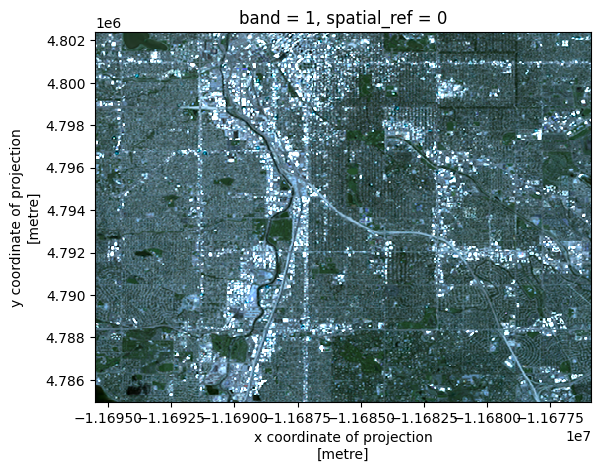

In [87]:
rgb_da = (
    xr.concat(
        [
            band_plot_dict['red'],
            band_plot_dict['green'],
            band_plot_dict['blue']
        ],
        dim='rgb')
)

def stretch_rgb(rgb_da, low, high, brighten):
    """
    Short description

    Long description...

    Parameters
    ----------
    rgb_da: array-like
      ...
    param2: ...
      ...

    Returns
    -------
    rgb_da: array-like
      ...
    """
    p_low, p_high = np.nanpercentile(rgb_da, (low, high))
    rgb_da = (rgb_da - p_low)  / (p_high - p_low) + brighten
    rgb_da = rgb_da.clip(0, 1)
    return rgb_da

rgb_da = stretch_rgb(rgb_da, 1, 98, .1)

rgb_da.plot.imshow(rgb='rgb')
rgb_da.hvplot.rgb(geo=True, x='x', y='y', bands='rgb')

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Plot CIR</div></div><div class="callout-body-container callout-body"><p>Now, plot a false color RGB image. CIR images have the following
bands:</p>
<ul>
<li>red becomes NIR</li>
<li>green becomes red</li>
<li>blue becomes green</li>
</ul></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-extra"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Looking for an Extra Challenge?: Adjust the levels</div></div><div class="callout-body-container callout-body"><p>You may notice that the NIR band in this image is very bright. Can
you adjust it so it is balanced more effectively by the other bands?</p></div></div>

In [88]:
%store denver_ndvi_da

Stored 'denver_ndvi_da' (DataArray)
